In [1]:
%matplotlib inline
%time from hikyuu.interactive import *
from pylab import plot
import h5py
from hikyuu.indicator import *

2025-03-23 11:50:29,557 [INFO] runing in interactive session [<module>] (C:\Users\25858\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hikyuu\__init__.py:118) [hikyuu::hku_info]
2025-03-23 11:50:29,560 [INFO] running in jupyter [<module>] (C:\Users\25858\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hikyuu\__init__.py:125) [hikyuu::hku_info]


2025-03-23 11:50:29.583 [HKU-I] - Using SQLITE3 BaseInfoDriver (BaseInfoDriver.cpp:57)
2025-03-23 11:50:29.605 [HKU-I] - Loading market information... (StockManager.cpp:482)
2025-03-23 11:50:29.606 [HKU-I] - Loading stock type information... (StockManager.cpp:500)
2025-03-23 11:50:29.606 [HKU-I] - Loading stock information... (StockManager.cpp:402)
2025-03-23 11:50:29.695 [HKU-I] - Loading stock weight... (StockManager.cpp:518)
2025-03-23 11:50:29.961 [HKU-I] - Loading block... (StockManager.cpp:113)
2025-03-23 11:50:30.195 [HKU-I] - Loading KData... (StockManager.cpp:117)
2025-03-23 11:50:30.196 [HKU-I] - Preloading all day kdata to buffer ! (StockManager.cpp:160)
2025-03-23 11:50:30.196 [HKU-I] - 0.59s Loaded Data. (StockManager.cpp:125)
CPU times: total: 953 ms
Wall time: 9.26 s


In [2]:
from tqdm import tqdm
from utils import *
h5_file = 'daily_rps.h5'
# df_rps10 = read_rps_file(h5_file, rps_period)
# df_rps20 = read_rps_file(h5_file, rps_period)
df_rps50 = read_rps_file(h5_file, 50)
# df_rps120 = read_rps_file(h5_file, 120)
# df_rps250 = read_rps_file(h5_file, 250)

读取 daily_rps.h5 中的RPS50数据...


读取RPS50数据: 100%|████████████████████████| 292/292 [00:30<00:00,  9.50it/s]


共读取 292 个交易日的RPS50数据
共涉及 3401 只股票


In [2]:
class RPSSignal(SignalBase):
    def __init__(self, n=20):
        super(RPSSignal, self).__init__("RPSSignal")
        self.set_param("n", n)

    def _clone(self):
        return RPSSignal()

    # def rps(self, code, n=50):
        # rpsdf = df_rps50
        # match n:
        #     case 50:
        #         rpsdf = df_rps50
        #     case 120:
        #         rpsdf = df_rps120
        #     case 250:
        #         rpsdf = df_rps250
        #     case _:
        #         print("err: unsupport rps: " + str(n))
        #         return
        # fake = '000001'
        # if code not in rpsdf.columns:
        #     print("err: " + code + " has no rps " + str(n))
        #     code = fake
        # # print(f"read rps{n} of {code}")
        # return df_to_ind(rpsdf, code, col_date='datetime')
    
    def _calculate(self, k_data):
        n = self.get_param("n")
        code = k_data.get_stock().code

        #准备数据
        close = CLOSE(k_data)
        high = HIGH(k_data)
        low = LOW(k_data)
        volume = VOL(k_data)
        # 计算各种均线
        ma10 = DISCARD(MA(close, 10), discard=10)
        ma20 = DISCARD(MA(close, 20), discard=20)
        ma200 = DISCARD(MA(close, 200), discard=200)
        ma250 = DISCARD(MA(close, 250), discard=250)

        # SXHCG2: 均线多头排列条件
        # SXHCG20: 收盘价站上20日线
        sxhcg20 = close > ma20
        
        # SXHCG21: 过去30天中至少25天收盘价高于250日均线
        sxhcg21 = COUNT(close > ma250, 30) >= 25
        
        # SXHCG22: 过去30天中至少25天收盘价高于200日均线
        sxhcg22 = COUNT(close > ma200, 30) >= 25
        
        # SXHCG23: 过去10天中至少9天收盘价高于20日均线
        sxhcg23 = COUNT(close > ma20, 10) >= 9
        
        # SXHCG24: 过去4天中至少3天收盘价高于10日线和20日线
        sxhcg24 = (COUNT(close > ma10, 4) >= 3) & (COUNT(close > ma20, 4) >= 3)
        
        # SXHCG2: 综合均线多头排列条件
        sxhcg2 = sxhcg20 & sxhcg21 & sxhcg22 & (sxhcg23 | sxhcg24)

        sxhcg2 = DISCARD(sxhcg2, discard=250)

        

        sell = close < ma10
        
        for i in range(sxhcg2.discard, len(k_data)):
            # print(sxhcg2[i])
            if sxhcg2[i]:
                # print(str(sxhcg2[i])+"buy" + str(k_data[i].datetime))
                self._add_buy_signal(k_data[i].datetime)
            elif sell:
                # print(str(sxhcg2[i])+"sell")
                self._add_sell_signal(k_data[i].datetime)
        
        # c = CLOSE(k)
        # h = REF(HHV(c, n), 1)  # 前n日高点
        # L = REF(LLV(c, n), 1)  # 前n日低点
        # for i in range(h.discard, len(k)):
        #     if (c[i] >= h[i]):
        #         self._add_buy_signal(k[i].datetime)
        #     elif (c[i] <= L[i]):
        #         self._add_sell_signal(k[i].datetime)

In [14]:
# 测试对象
from utils import *
stks = [get_stock(g) for g in read_guchi("guchi_test.txt")]
# stks = [get_stock(g) for g in read_guchi("guchi.EBK")]
# stks = [s for s in stks if s.valid]
stks = [s for s in sm.get_block("指数板块", "沪深300")]
# stks = [get_stock("sz003041"), get_stock("sz001309"),get_stock("sz301086")]
time = Datetime(20240101)
money = 100000
len(stks)

300

In [31]:

# 创建一个系统策略
my_mm = MM_Nothing()
# my_mm = MM_FixedCapitalFunds(10)
# my_sg = SG_Flex(EMA(CLOSE(), n=5), slow_n=10)
my_sg = RPSSignal(10)
my_sys = SYS_Simple(sg=my_sg, mm=my_mm)
# 创建一个选择算法，用于在每日选定交易系统
# my_se = SE_Fixed(stks, my_sys)
my_se = SE_Signal(stks, my_sys)
# 创建一个资产分配器，用于确定如何在选定的交易系统中进行资产分配
my_af = AF_EqualWeight()
# 创建资产组合
my_tm = crtTM(time, money)
my_pf = PF_Simple(tm=my_tm, af=my_af, se=my_se, adjust_mode='day', adjust_cycle=1)
# my_pf = PF_WithoutAF(tm=my_tm, se=my_se, adjust_mode='day', adjust_cycle=1)

In [32]:
# 运行投资组合
%time my_pf.run(Query(time - TimeDelta(days=500)),force=True)

CPU times: total: 859 ms
Wall time: 919 ms


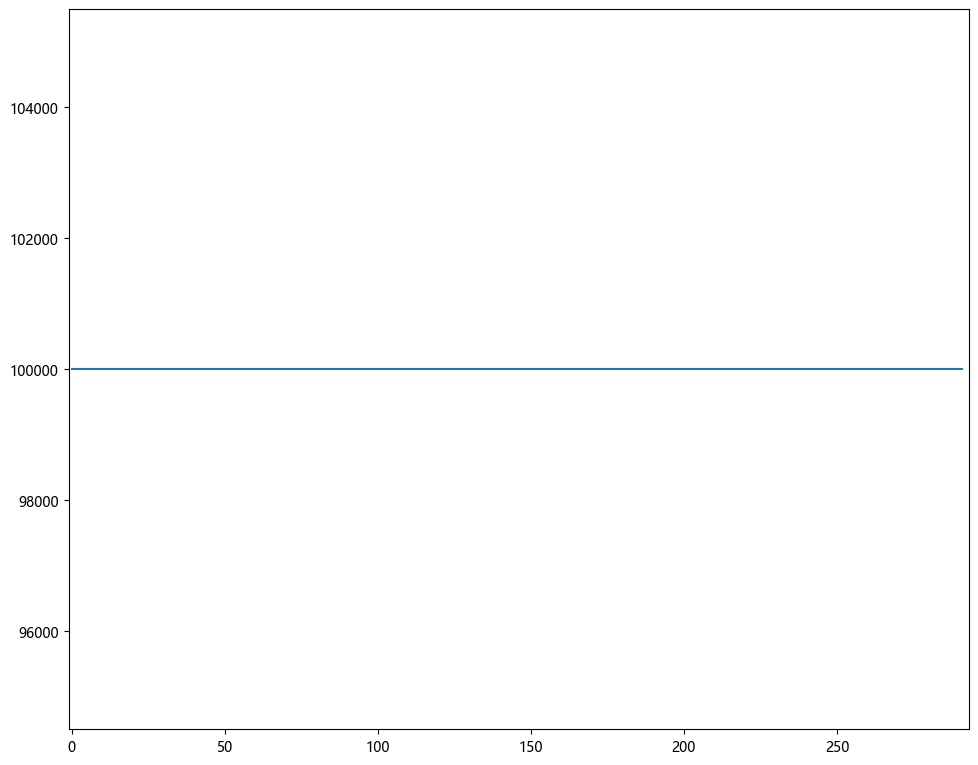

In [33]:
x = my_tm.get_funds_curve(sm.get_trading_calendar(Query(time)))
PRICELIST(x).plot()



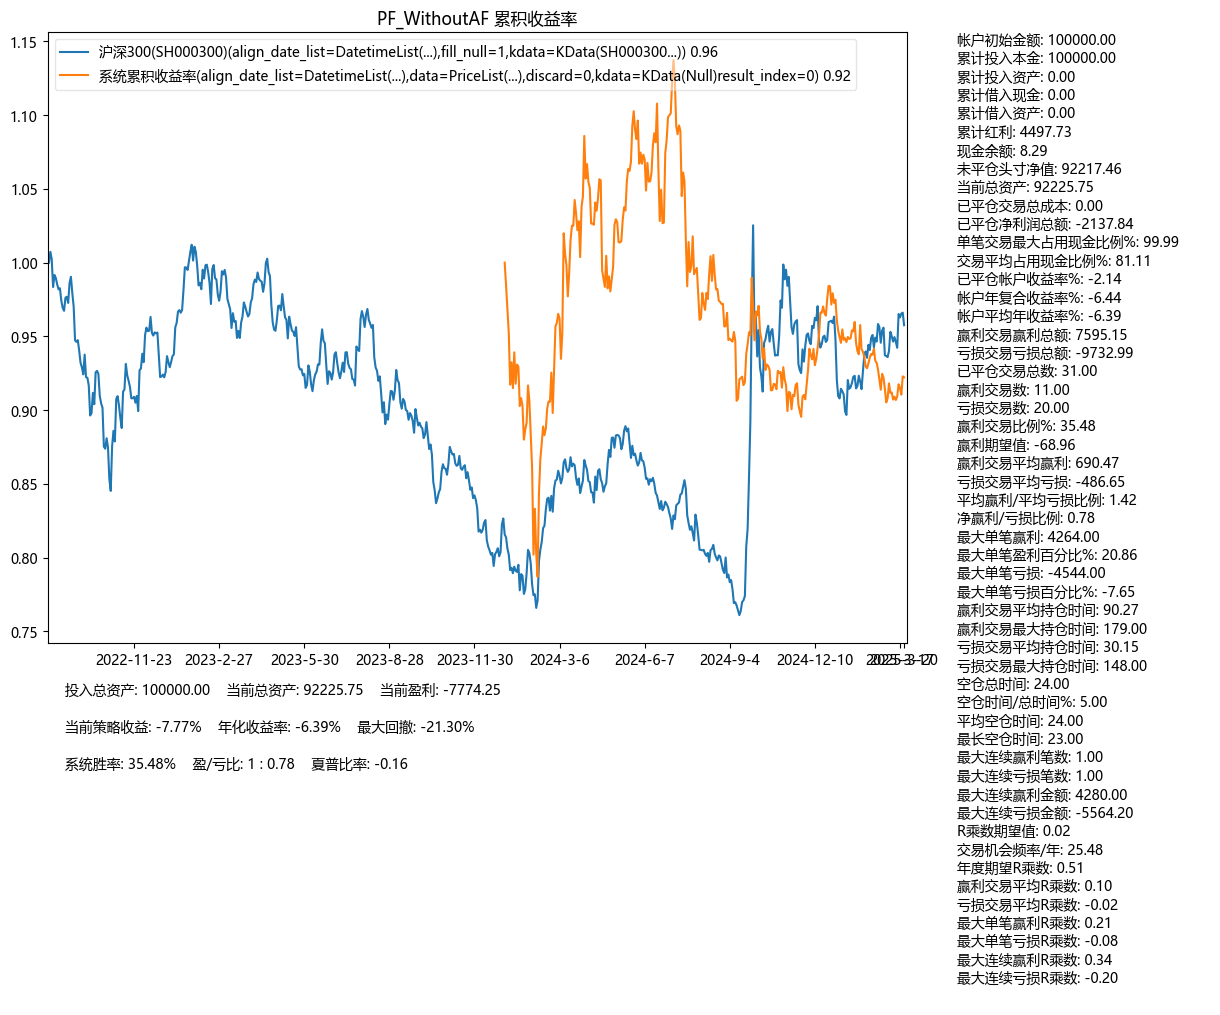

In [30]:
my_pf.performance()

In [26]:
df = my_tm.get_trade_list().to_df()
# df.query('业务名称 == "BUY"')
df

,证券代码,证券名称,业务名称,计划交易价格,实际成交价格,目标价格,成交数量,佣金,印花税,过户费,其它成本,交易总成本,止损价,现金余额,信号来源
交易日期,,,,,,,,,,,,,,,
2024-01-01,,,INIT,100000.00,100000.00,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,100000.00,--
2024-01-02,SZ300433,蓝思科技,BUY,13.06,13.06,NaN,7600,0.0,0.0,0.0,0.0,0.0,0.0,744.00,SG
2024-01-02,SH601398,工商银行,BUY,4.79,4.79,NaN,100,0.0,0.0,0.0,0.0,0.0,0.0,265.00,SG
2024-01-11,SH688036,传音控股,BUY,133.79,133.79,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0,131.21,SG
2024-03-05,SH688041,海光信息,BUY,86.30,86.30,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0,44.91,SG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-05,SH688981,中芯国际,BUY,101.37,101.37,NaN,4,0.0,0.0,0.0,0.0,0.0,0.0,36.30,SG
2025-02-21,SH688126,沪硅产业,BUY,20.56,20.56,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0,15.74,SG
2025-02-25,SH688981,中芯国际,SELL,101.28,101.28,NaN,4,0.0,0.0,0.0,0.0,0.0,0.0,420.86,SG


In [130]:

query = Query(-300)
k_data = get_stock("sz003041").get_kdata(query)

#准备数据
close = CLOSE(k_data)
high = HIGH(k_data)
low = LOW(k_data)
volume = VOL(k_data)
# 计算各种均线
ma10 = DISCARD(MA(close, 10), discard=10)
ma20 = DISCARD(MA(close, 20), discard=20)
ma200 = DISCARD(MA(close, 200), discard=200)
ma250 = DISCARD(MA(close, 250), discard=250)

# SXHCG2: 均线多头排列条件
# SXHCG20: 收盘价站上20日线
sxhcg20 = close > ma20

# SXHCG21: 过去30天中至少25天收盘价高于250日均线
sxhcg21 = COUNT(close > ma250, 30)

# SXHCG22: 过去30天中至少25天收盘价高于200日均线
sxhcg22 = COUNT(close > ma200, 30)

# SXHCG23: 过去10天中至少9天收盘价高于20日均线
sxhcg23 = COUNT(close > 1, 10)

# SXHCG24: 过去4天中至少3天收盘价高于10日线和20日线
sxhcg24 = (COUNT(close > ma10, 4) >= 3) & (COUNT(close > ma20, 4) >= 3)

# SXHCG2: 综合均线多头排列条件
sxhcg2 = sxhcg20 & sxhcg21 & sxhcg22 & (sxhcg23 | sxhcg24)

ma_list = [close, ma10, ma20, ma200, ma250, sxhcg20, sxhcg21, sxhcg22, sxhcg23, close >= low]
df = concat_to_df(sm.get_trading_calendar(query), ma_list, head_stock_code=False, head_ind_name=True)
df



,date,CLOSE,DISCARD,DISCARD,DISCARD,DISCARD,GT,COUNT,COUNT,COUNT,GE
0,2023-12-20 00:00:00,16.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-12-21 00:00:00,17.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-12-22 00:00:00,16.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-12-25 00:00:00,16.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-12-26 00:00:00,16.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
295,2025-03-14 00:00:00,27.23,26.047,25.9630,17.00915,16.15780,NaN,NaN,NaN,NaN,NaN
296,2025-03-17 00:00:00,26.76,26.211,25.9805,17.07510,16.21704,NaN,NaN,NaN,NaN,NaN
297,2025-03-18 00:00:00,26.34,26.301,25.9975,17.13970,16.27592,NaN,NaN,NaN,NaN,NaN
298,2025-03-19 00:00:00,27.28,26.486,26.0255,17.20615,16.33752,NaN,NaN,NaN,NaN,NaN
